In [2]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%matplotlib inline

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import os
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest

import warnings

warnings.filterwarnings('ignore', category=UserWarning)

In [4]:
# 파일들이 있는 폴더 경로
folder_path = 'C:/Users/mumu1/Desktop/project_movie_data/project_dataset'

# 파일 이름을 변수에 할당
o_df_customers = pd.read_csv(os.path.join(folder_path, 'olist_customers_dataset.csv'), encoding='ISO-8859-1')
o_df_geolocation = pd.read_csv(os.path.join(folder_path, 'olist_geolocation_dataset.csv'), encoding='ISO-8859-1')
o_df_order_items = pd.read_csv(os.path.join(folder_path, 'olist_order_items_dataset.csv'), encoding='ISO-8859-1')
o_df_order_payments = pd.read_csv(os.path.join(folder_path, 'olist_order_payments_dataset.csv'), encoding='ISO-8859-1')
o_df_order_reviews = pd.read_csv(os.path.join(folder_path, 'olist_order_reviews_dataset.csv'), encoding='ISO-8859-1')
o_df_products = pd.read_csv(os.path.join(folder_path, 'olist_products_dataset.csv'), encoding='ISO-8859-1')
o_df_sellers = pd.read_csv(os.path.join(folder_path, 'olist_sellers_dataset.csv'), encoding='ISO-8859-1')
o_df_product_category_name_translation = pd.read_csv(os.path.join(folder_path, 'product_category_name_translation.csv'), encoding='utf-8-sig')
o_df_orders = pd.read_csv(os.path.join(folder_path, 'olist_orders_dataset.csv'), encoding='ISO-8859-1')

print("✅ 모든 파일이 개별적으로 메모리에 로드되었습니다.")

# 카피본 생성
df_customers = o_df_customers.copy()
df_geolocation = o_df_geolocation.copy()
df_order_items = o_df_order_items.copy()
df_order_payments = o_df_order_payments.copy()
df_order_reviews = o_df_order_reviews.copy()
df_products = o_df_products.copy()
df_sellers = o_df_sellers.copy()
df_product_category_name_translation = o_df_product_category_name_translation.copy()
df_order = o_df_orders.copy()

✅ 모든 파일이 개별적으로 메모리에 로드되었습니다.


In [5]:
# 이상치 탐색
dfs = {
    "customers": df_customers,
    "geolocation": df_geolocation,
    "order_items": df_order_items,
    "order_payments": df_order_payments,
    "order_reviews": df_order_reviews,
    "orders": df_order,
    "products": df_products,
    "sellers": df_sellers,
    "product_category": df_product_category_name_translation
}

# 0, 음수 비율 + IQR 이상치 탐색 함수
def check_data_quality(df, name):
    print(f"\n===== {name} =====")
    num_cols = df.select_dtypes(include="number").columns
    if len(num_cols) == 0:
        print("수치형 컬럼 없음")
        return
    for col in num_cols:
        total = len(df)

        # 0 / 음수 비율
        zero_ratio = (df[col] == 0).sum() / total * 100
        neg_ratio = (df[col] < 0).sum() / total * 100

        # IQR 이상치 비율
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        outlier_ratio = ((df[col] < lower) | (df[col] > upper)).sum() / total * 100

        # 출력
        if zero_ratio > 0 or neg_ratio > 0 or outlier_ratio > 0:
            print(f"- {col}: 0 비율={zero_ratio:.2f}%, 음수 비율={neg_ratio:.2f}%, 이상치 비율={outlier_ratio:.2f}%")

# 실행
for name, df in dfs.items():
    check_data_quality(df, name)



===== customers =====

===== geolocation =====
- geolocation_lat: 0 비율=0.00%, 음수 비율=99.87%, 이상치 비율=16.82%
- geolocation_lng: 0 비율=0.00%, 음수 비율=100.00%, 이상치 비율=4.23%

===== order_items =====
- order_item_id: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=12.41%
- price: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=7.48%
- freight_value: 0 비율=0.34%, 음수 비율=0.00%, 이상치 비율=10.77%

===== order_payments =====
- payment_sequential: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=4.36%
- payment_installments: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=6.08%
- payment_value: 0 비율=0.01%, 음수 비율=0.00%, 이상치 비율=7.68%

===== order_reviews =====
- review_score: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=14.69%

===== orders =====
수치형 컬럼 없음

===== products =====
- product_name_lenght: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=0.88%
- product_description_lenght: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=6.31%
- product_photos_qty: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=2.58%
- product_weight_g: 0 비율=0.01%, 음수 비율=0.00%, 이상치 비율=13.81%
- product_length_cm: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=4.19%
- pr

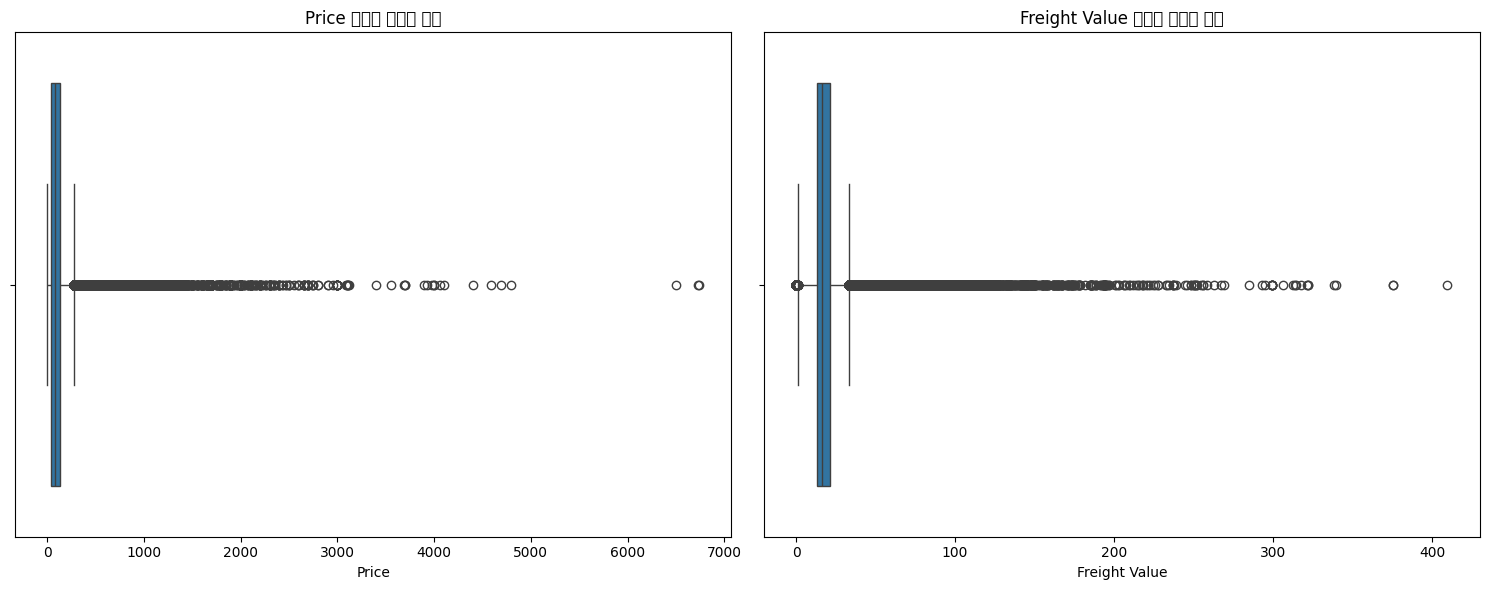

In [6]:
# 이상치 확인: order_item['price'],['fight_value]: 시각화
# 고가의 구매제품 존재, 
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. price 컬럼의 상자 그림
sns.boxplot(x=df_order_items['price'], ax=axes[0])
axes[0].set_title('Price 컬럼의 이상치 분포')
axes[0].set_xlabel('Price')

# 2. freight_value 컬럼의 상자 그림
sns.boxplot(x=df_order_items['freight_value'], ax=axes[1])
axes[1].set_title('Freight Value 컬럼의 이상치 분포')
axes[1].set_xlabel('Freight Value')

# 그래프 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

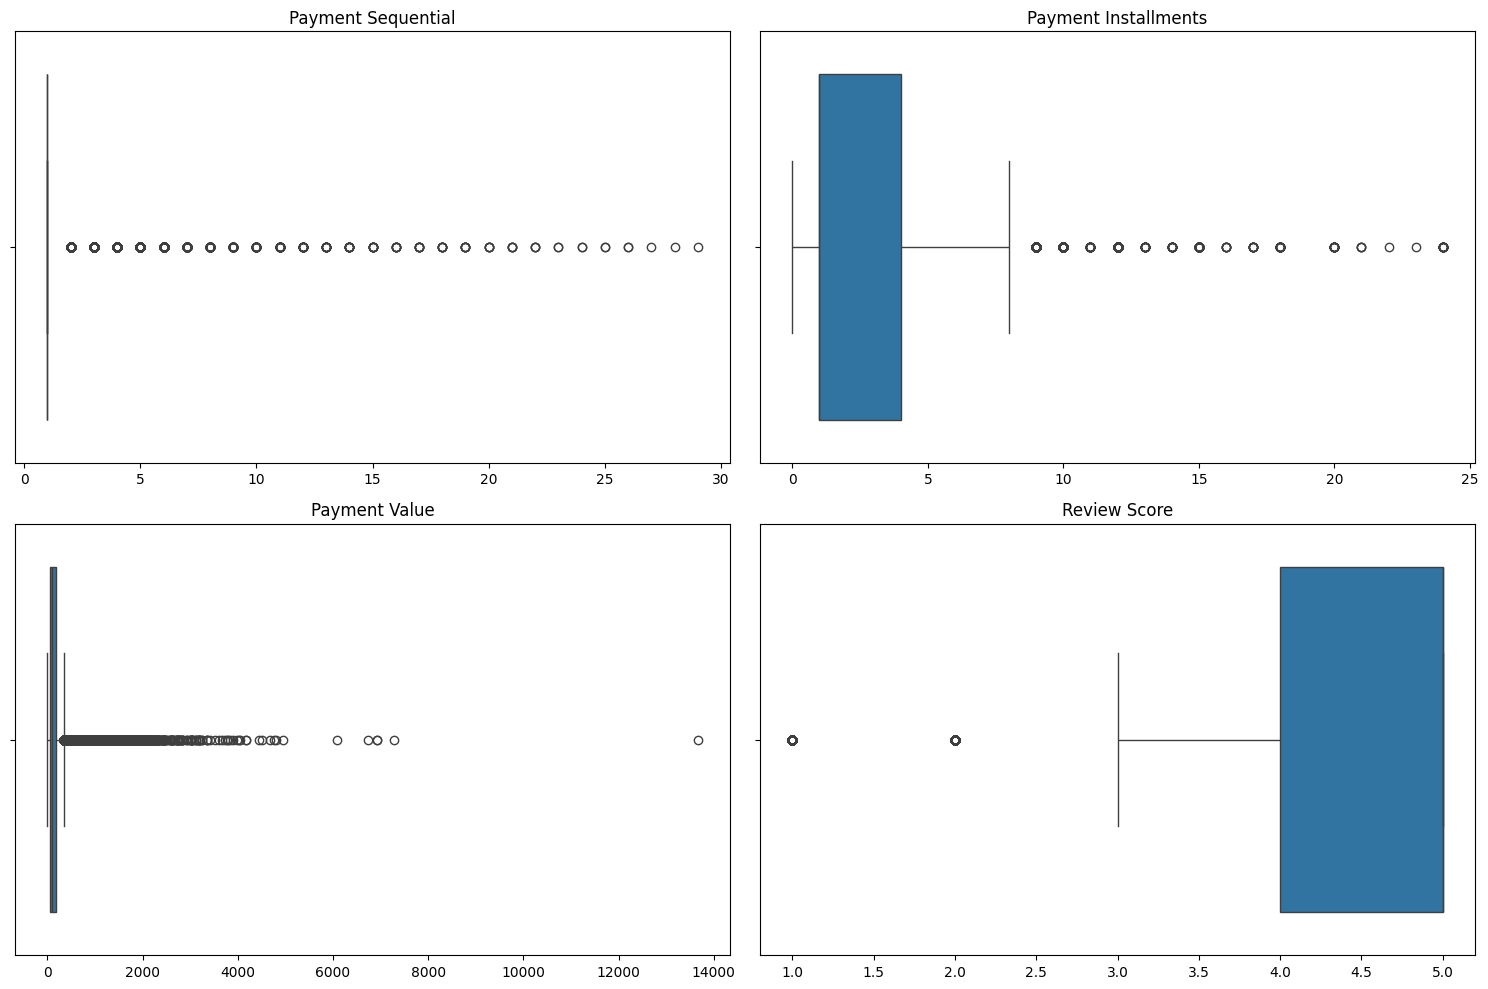

In [7]:
# 이상치 시각화: 
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. payment_sequential
sns.boxplot(x=df_order_payments['payment_sequential'], ax=axes[0, 0])
axes[0, 0].set_title('Payment Sequential')
axes[0, 0].set_xlabel('')

# 2. payment_installments
sns.boxplot(x=df_order_payments['payment_installments'], ax=axes[0, 1])
axes[0, 1].set_title('Payment Installments')
axes[0, 1].set_xlabel('')

# 3. payment_value
sns.boxplot(x=df_order_payments['payment_value'], ax=axes[1, 0])
axes[1, 0].set_title('Payment Value')
axes[1, 0].set_xlabel('')

# 4. review_score
sns.boxplot(x=df_order_reviews['review_score'], ax=axes[1, 1])
axes[1, 1].set_title('Review Score')
axes[1, 1].set_xlabel('')

# 그래프 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [8]:
# payment_sequential 이상치 확인

# payment_sequential = 29 인 주문 찾기
# seq_29_orders = df_order_payments[df_order_payments['payment_sequential'] == 29]['order_id'].unique()
# print("payment_sequential=29 주문 수:", len(seq_29_orders))

# 해당 주문 상세 결제 내역 확인
# df_seq_29 = df_order_payments[df_order_payments['order_id'].isin(seq_29_orders)]
# df_seq_29 = df_seq_29.sort_values(['order_id','payment_sequential'])
# print(df_seq_29.head(20))

# 1) payment_sequential ≥ 10인 주문 ID 추출
hi_seq_orders = (
    df_order_payments.loc[df_order_payments["payment_sequential"] >= 10, "order_id"]
    .unique()
)

# 2) 해당 주문들의 결제 상세 내역 추출
hi_seq_details = (
    df_order_payments[df_order_payments["order_id"].isin(hi_seq_orders)]
    .copy()
)

# 3) 결제ID 단위 그룹핑 (order_id + payment_sequential)
grouped_by_payment = (
    hi_seq_details
    .groupby(["order_id", "payment_sequential"], as_index=False)
    .agg(
        payment_type=("payment_type", "first"),
        installments=("payment_installments", "first"),
        value_sum=("payment_value", "sum"),
        record_count=("payment_value", "count")
    )
    .sort_values(["order_id", "payment_sequential"])
)

print("=== 결제ID 단위 그룹핑 (상위 20행) ===")
print(grouped_by_payment.head(20))

# 4) 주문 단위 요약 (결제 건수, 합계)
summary_by_order = (
    grouped_by_payment
    .groupby("order_id", as_index=False)
    .agg(
        payments_cnt=("payment_sequential", "max"),
        payment_sum=("value_sum", "sum")
    )
    .sort_values("payments_cnt", ascending=False)
)

print("\n=== 주문 단위 요약 (Top 10) ===")
print(summary_by_order.head(10))

=== 결제ID 단위 그룹핑 (상위 20행) ===
                            order_id  payment_sequential payment_type  \
0   0bbb3f7791a87d0307555e57da3a1ff1                   1  credit_card   
1   0bbb3f7791a87d0307555e57da3a1ff1                   2      voucher   
2   0bbb3f7791a87d0307555e57da3a1ff1                   3      voucher   
3   0bbb3f7791a87d0307555e57da3a1ff1                   4      voucher   
4   0bbb3f7791a87d0307555e57da3a1ff1                   5      voucher   
5   0bbb3f7791a87d0307555e57da3a1ff1                   6      voucher   
6   0bbb3f7791a87d0307555e57da3a1ff1                   7      voucher   
7   0bbb3f7791a87d0307555e57da3a1ff1                   8      voucher   
8   0bbb3f7791a87d0307555e57da3a1ff1                   9      voucher   
9   0bbb3f7791a87d0307555e57da3a1ff1                  10      voucher   
10  0bbb3f7791a87d0307555e57da3a1ff1                  11      voucher   
11  1a611328643ae11146ba09a4425d2e12                   1  credit_card   
12  1a611328643ae11146

In [9]:
# 8개 데이터프레임의 결측값 분석
def check_missing(dfs, df_names):
    for df, name in zip(dfs, df_names):
        print(f"\n📊 {name} 데이터프레임 결측값 분석")
        
        missing_info = df.isnull().sum()
        m_pct = (missing_info / len(df)) * 100
        
        if missing_info.sum() == 0:
            print("✅ 결측값 없음. 완전")
        else:
            print("⚠️ 결측치 존재")
            missing_sum = pd.DataFrame({
                '결측수': missing_info,
                '결측율(%)': m_pct,
            }).round(2)
            missing_sum = missing_sum[missing_sum['결측수'] > 0]
            display(missing_sum)

# 사용 예시
original_dfs = [ 
    o_df_customers, o_df_geolocation, o_df_order_items,
    o_df_order_payments, o_df_order_reviews, o_df_products,
    o_df_sellers, o_df_product_category_name_translation,
]

df_names = [
    "customers", "geolocation", "order_items",
    "order_payments", "order_reviews", "products",
    "sellers", "product_category_name_translation",
]

check_missing(original_dfs, df_names)


📊 customers 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 geolocation 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 order_items 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 order_payments 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 order_reviews 데이터프레임 결측값 분석
⚠️ 결측치 존재


,결측수,결측율(%)
review_comment_title,87656,88.34
review_comment_message,58247,58.70



📊 products 데이터프레임 결측값 분석
⚠️ 결측치 존재


,결측수,결측율(%)
product_category_name,610,1.85
product_name_lenght,610,1.85
product_description_lenght,610,1.85
product_photos_qty,610,1.85
product_weight_g,2,0.01
product_length_cm,2,0.01
product_height_cm,2,0.01
product_width_cm,2,0.01



📊 sellers 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 product_category_name_translation 데이터프레임 결측값 분석
✅ 결측값 없음. 완전


# 전처리

In [10]:
# df_products 

# 결측치: 삭제
# 이상치: 음수 없음, 0 삭제

# df_products.info() # 32951

# 결측치가 있는 모든 행 삭제
df_products = df_products.dropna()

# 결측치 삭제 후 DataFrame 출력
print("결측치 삭제 후 DataFrame:")
print(df_products.info())
print("-" * 30)

# 결측치 삭제 후 결측치 수 확인
print("결측치 삭제 후 결측치 개수:")
print(df_products.isnull().sum())

# df_products.describe()

# 마이너스 값 없음
# 0값을 확인할 열 목록
zero_check_columns = [
    'product_name_lenght',
    'product_description_lenght',
    'product_photos_qty',
    'product_weight_g',
    'product_length_cm',
    'product_height_cm',
    'product_width_cm'
]

# 각 열의 0값 비율 계산
zero_ratios = (df_products[zero_check_columns] == 0).mean() * 100

print("각 열의 0값 비율 (%):")
print(zero_ratios)

# 'product_weight_g' 열의 0값을 갖는 행을 삭제
df_products_cleaned = df_products[df_products['product_weight_g'] != 0]

# 'product_weight_g' 열에서 0이 모두 삭제되었는지 확인
print("'product_weight_g' 열의 0값 개수:")
print((df_products_cleaned['product_weight_g'] == 0).sum())

결측치 삭제 후 DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 32340 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32340 non-null  object 
 1   product_category_name       32340 non-null  object 
 2   product_name_lenght         32340 non-null  float64
 3   product_description_lenght  32340 non-null  float64
 4   product_photos_qty          32340 non-null  float64
 5   product_weight_g            32340 non-null  float64
 6   product_length_cm           32340 non-null  float64
 7   product_height_cm           32340 non-null  float64
 8   product_width_cm            32340 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.5+ MB
None
------------------------------
결측치 삭제 후 결측치 개수:
product_id                    0
product_category_name         0
product_name_lenght           0
product_description_lenght    0
product_photos_qt

In [11]:
df_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


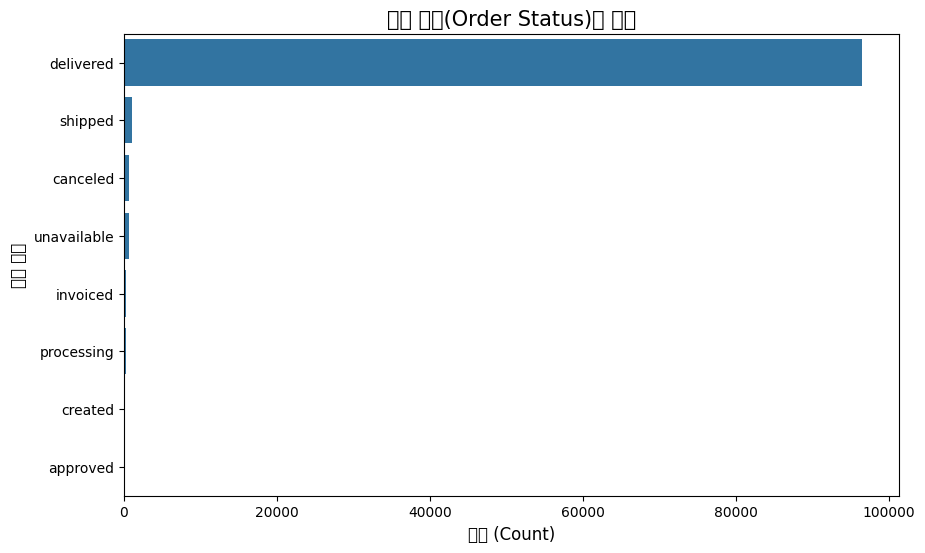

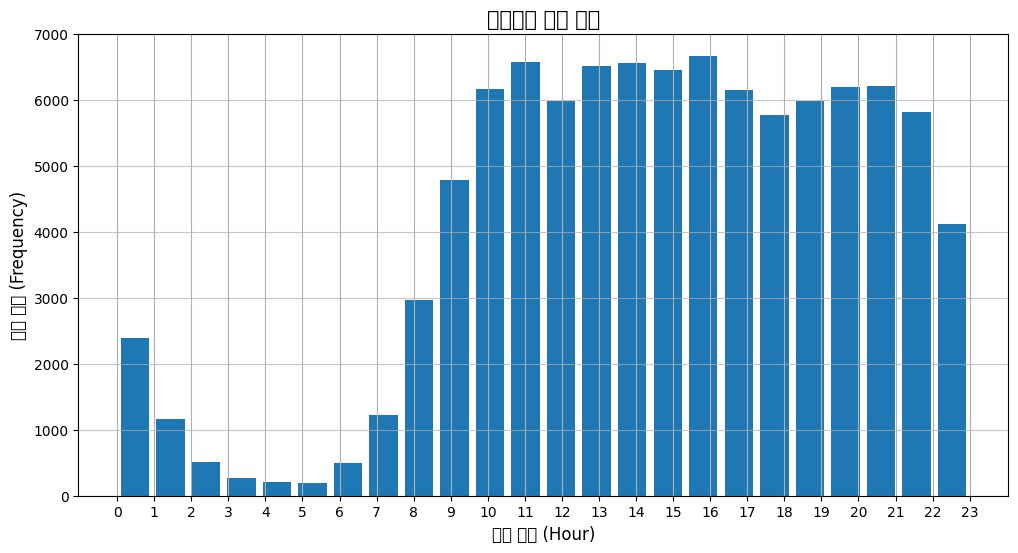

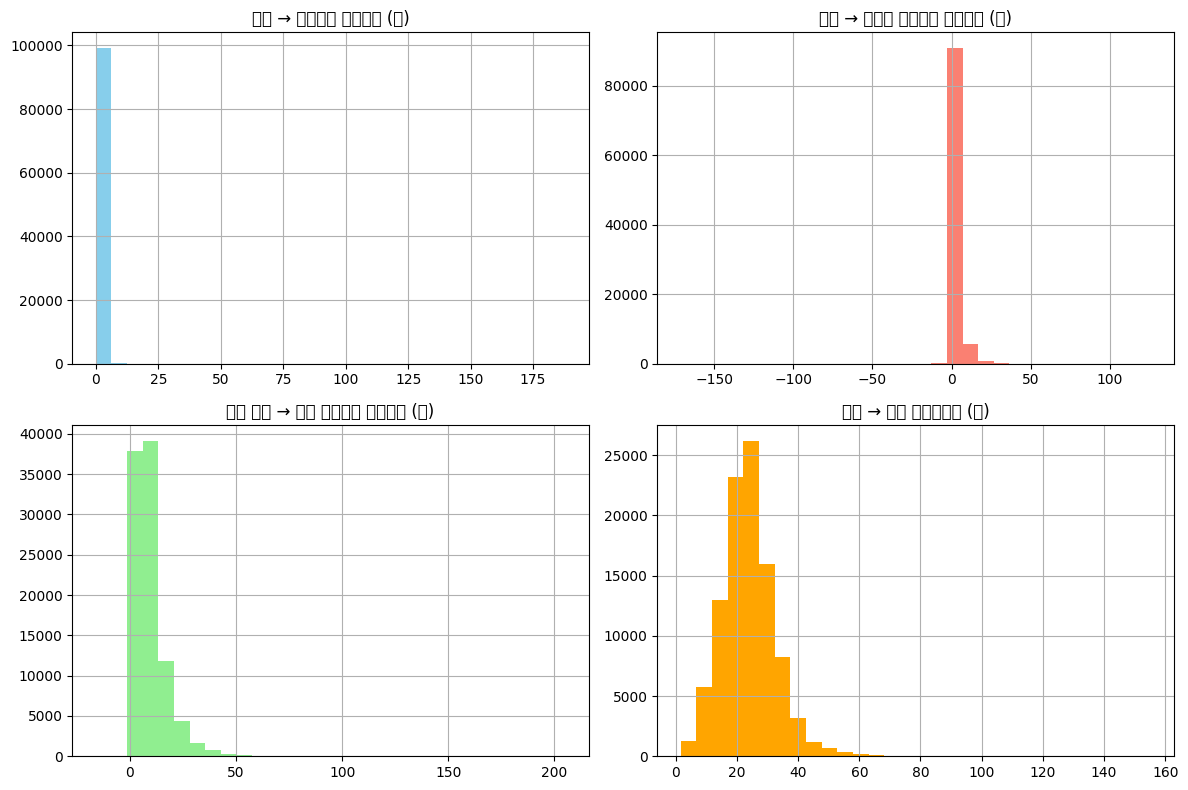

In [12]:
# EDA  df_order

# df_order.info()

# order_status 컬럼의 각 값의 개수를 막대 그래프.
plt.figure(figsize=(10, 6))
sns.countplot(data=df_order, y='order_status', order=df_order['order_status'].value_counts().index)
plt.title('주문 상태(Order Status)별 개수', fontsize=15)
plt.xlabel('개수 (Count)', fontsize=12)
plt.ylabel('주문 상태', fontsize=12)
plt.show()

# 1. 날짜/시간 관련 컬럼들을 datetime 타입으로 변환
# errors='coerce'는 변환 중 오류 발생 시 해당 값을 NaT(Not a Time)으로 처리
time_cols = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]
for col in time_cols:
    df_order[col] = pd.to_datetime(df_order[col], errors='coerce')

# 2. '주문 시간(hour)'을 추출하여 히스토그램
plt.figure(figsize=(12, 6))
df_order['order_purchase_timestamp'].dt.hour.hist(bins=24, rwidth=0.8) # 24시간을 기준으로
plt.title('시간대별 주문 분포', fontsize=15)
plt.xlabel('주문 시간 (Hour)', fontsize=12)
plt.ylabel('주문 건수 (Frequency)', fontsize=12)
plt.xticks(range(0, 24)) # x축 눈금을 0부터 23까지 표시
plt.grid(axis='y', alpha=0.7)
plt.show()

# 날짜 차이 계산 (일 단위)
df_order['purchase_to_approved'] = (df_order['order_approved_at'] - df_order['order_purchase_timestamp']).dt.total_seconds() / 86400
df_order['approved_to_carrier'] = (df_order['order_delivered_carrier_date'] - df_order['order_approved_at']).dt.total_seconds() / 86400
df_order['carrier_to_customer'] = (df_order['order_delivered_customer_date'] - df_order['order_delivered_carrier_date']).dt.total_seconds() / 86400
df_order['purchase_to_estimated'] = (df_order['order_estimated_delivery_date'] - df_order['order_purchase_timestamp']).dt.total_seconds() / 86400

# 시각화 (2행 2열)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

df_order['purchase_to_approved'].hist(bins=30, ax=axes[0,0], color='skyblue')
axes[0,0].set_title('구매 → 승인까지 소요시간 (일)')

df_order['approved_to_carrier'].hist(bins=30, ax=axes[0,1], color='salmon')
axes[0,1].set_title('승인 → 택배사 전달까지 소요시간 (일)')

df_order['carrier_to_customer'].hist(bins=30, ax=axes[1,0], color='lightgreen')
axes[1,0].set_title('배송 시작 → 고객 수령까지 소요시간 (일)')

df_order['purchase_to_estimated'].hist(bins=30, ax=axes[1,1], color='orange')
axes[1,1].set_title('구매 → 예상 배송일까지 (일)')

plt.tight_layout()
plt.show()

In [13]:
# 이상치 탐지 
df_order_items.describe() # 음수 없음

# 0값 탐지
df_combined_outliers = df_order_items[(df_order_items['price'] == 0) | (df_order_items['freight_value'] == 0)]
print(len(df_combined_outliers))

# 결측률 확인
zero_rate = (df_order_items[['price','freight_value']] == 0).mean()
print(zero_rate)

# 0인 값 삭제
df_order_items = df_order_items[(df_order_items['price'] != 0) & (df_order_items['freight_value'] != 0)]

# 0이 모두 삭제되었는지 확인
print("df_order_items 0값 개수:")
print((df_order_items['freight_value'] == 0).sum())

383
price            0.0000
freight_value    0.0034
dtype: float64
df_order_items 0값 개수:
0


📌 피어슨 상관계수:
                   price  freight_value
price          1.000000       0.414882
freight_value  0.414882       1.000000

📌 스피어맨 상관계수:
                   price  freight_value
price          1.000000       0.438325
freight_value  0.438325       1.000000


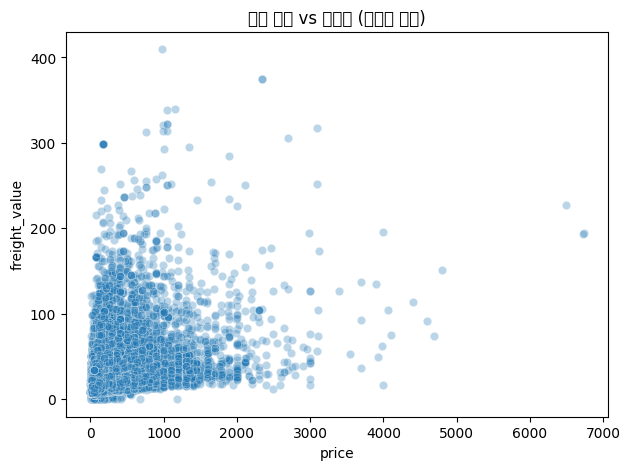

전체 데이터 행 수: 112267
IsolationForest 모델이 탐지한 이상치 개수: 1122
이상치 비율: 0.999403208422778 %


C:\Users\mumu1\AppData\Local\Temp\ipykernel_3008\2327549734.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_order_items['outlier'] = iso.fit_predict(df_order_items[['price','freight_value']])
C:\Users\mumu1\AppData\Local\Temp\ipykernel_3008\2327549734.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_order_items["is_outlier"] = (df_order_items["outlier"] == -1).astype(int)


In [14]:
# df_order_items 가격과 배송료 상관관계

# 1) 기본 상관관계 확인
corr_pearson = df_order_items[['price','freight_value']].corr(method='pearson')
corr_spearman = df_order_items[['price','freight_value']].corr(method='spearman')

print("📌 피어슨 상관계수:\n", corr_pearson)
print("\n📌 스피어맨 상관계수:\n", corr_spearman)

# 2) 산점도 (이상치 포함)
plt.figure(figsize=(7,5))
sns.scatterplot(x='price', y='freight_value', data=df_order_items, alpha=0.3)
plt.title("상품 가격 vs 배송료 (이상치 포함)")
plt.show()

# 3) IsolationForest로 이상치 탐지
iso = IsolationForest(contamination=0.01, random_state=42)
df_order_items['outlier'] = iso.fit_predict(df_order_items[['price','freight_value']])

# -1 = 이상치, 1 = 정상
print("전체 데이터 행 수:", len(df_order_items))
print("IsolationForest 모델이 탐지한 이상치 개수:", (df_order_items['outlier']==-1).sum())
print("이상치 비율:", (df_order_items['outlier']==-1).mean()*100, "%")

# 삭제하지 않고 별도 태그로 나눠서 관리
# df_order_items (원본) → 이상치 포함 전체 데이터
# df_order_items[df_order_items["is_outlier"] == 0] → 이상치 제거 데이터
# 추후 “전체 평균 배송비” vs “이상치 제외 평균 배송비” 분석 예정
df_order_items["is_outlier"] = (df_order_items["outlier"] == -1).astype(int)

In [30]:
'''
df_order_reviews 전처리

- 전처리 전 
review_comment_title: 결측치 88% → 고객 대부분이 제목은 아예 작성하지 않음.
review_comment_message: 결측치 59% → 절반 이상이 코멘트를 남기지 않음.
review_score → 전부 존재
- 전처리 후
has_text → 0 = 점수만, 1 = 점수+텍스트
'''
# 목적: 배송 지연 ↔ 리뷰 점수, 텍스트 작성 여부 분석

# 1) 공백/빈 문자열을 결측으로 정규화
for col in ["review_comment_title", "review_comment_message"]:
    df_order_reviews[col] = df_order_reviews[col].astype("object")
    df_order_reviews[col] = df_order_reviews[col].apply(lambda x: x.strip() if isinstance(x, str) else x)
    df_order_reviews[col] = df_order_reviews[col].replace("", np.nan)

# 2) 결측 치환 (분석 구분을 위해 명시 텍스트 사용)
df_order_reviews["review_comment_title"]   = df_order_reviews["review_comment_title"].fillna("No Comment_title")
df_order_reviews["review_comment_message"] = df_order_reviews["review_comment_message"].fillna("No Comment_message")

# 3) 리뷰 작성 여부 (텍스트 기준)
df_order_reviews["has_text"] = (
    (df_order_reviews["review_comment_title"]   != "No Comment_title") |
    (df_order_reviews["review_comment_message"] != "No Comment_message")
).astype(int)

# 4) 타입 변환
df_order_reviews["review_score"] = pd.to_numeric(df_order_reviews["review_score"], errors="coerce")
df_order_reviews["review_creation_date"] = pd.to_datetime(df_order_reviews["review_creation_date"], errors="coerce")

# 5) 확인
print("✅ df_order_reviews preview")
print(df_order_reviews.head(3))
print("\n리뷰 총 개수:", len(df_order_reviews))
print("has_text 분포:")
print((df_order_reviews["has_text"].value_counts(normalize=True)*100).round(1))

✅ df_order_reviews preview
                          review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   

   review_score review_comment_title review_comment_message  \
0             4     No Comment_title     No Comment_message   
1             5     No Comment_title     No Comment_message   
2             5     No Comment_title     No Comment_message   

  review_creation_date  has_title  has_message  has_review  has_text  
0           2018-01-18          0            0           0         0  
1           2018-03-10          0            0           0         0  
2           2018-02-17          0            0           0         0  

리뷰 총 개수: 99224
has_text 분포:
has_text
0    57.0
1    43.0
Name: proportion, dtype: float64


In [16]:
## df_order_items 컬럼 추가
# df_order_items['The total order value'] : order_id별 총구매액
# df_order_items['Total Sales'] : 총매출

# 1. df_order_items['The total order value']  
total_price = df_order_items.groupby('order_id')['price'].transform('sum')
total_freight = df_order_items.groupby('order_id')['freight_value'].transform('sum')
df_order_items['The total order value'] = total_price + total_freight

# 2. 총매출 계산 (모든 주문총액 합계)
total_sales = df_order_items['The total order value'].sum()

# 3. 총매출을 새로운 컬럼으로 추가
# -> 각 행에 동일한 총매출 값이 들어감
df_order_items['Total Sales'] = total_sales

# 4. 특정 주문 확인 (예: 동일제품 2개 구매)
specific_order_id = '0008288aa423d2a3f00fcb17cd7d8719'
specific_order = df_order_items[df_order_items['order_id'] == specific_order_id]

# print("=== 특정 주문 상세 ===")
print(specific_order)
df_order_items.head()

# shipping_limit_date를 날짜로 변환
df_order_items['shipping_limit_date'] = pd.to_datetime(df_order_items['shipping_limit_date'], errors='coerce')

                            order_id  order_item_id  \
13  0008288aa423d2a3f00fcb17cd7d8719              1   
14  0008288aa423d2a3f00fcb17cd7d8719              2   

                          product_id                         seller_id  \
13  368c6c730842d78016ad823897a372db  1f50f920176fa81dab994f9023523100   
14  368c6c730842d78016ad823897a372db  1f50f920176fa81dab994f9023523100   

    shipping_limit_date  price  freight_value  outlier  is_outlier  \
13  2018-02-21 02:55:52   49.9          13.37        1           0   
14  2018-02-21 02:55:52   49.9          13.37        1           0   

    The total order value  Total Sales  
13                 126.54   20258168.9  
14                 126.54   20258168.9  


C:\Users\mumu1\AppData\Local\Temp\ipykernel_3008\2152631415.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_order_items['The total order value'] = total_price + total_freight
C:\Users\mumu1\AppData\Local\Temp\ipykernel_3008\2152631415.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_order_items['Total Sales'] = total_sales
C:\Users\mumu1\AppData\Local\Temp\ipykernel_3008\2152631415.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

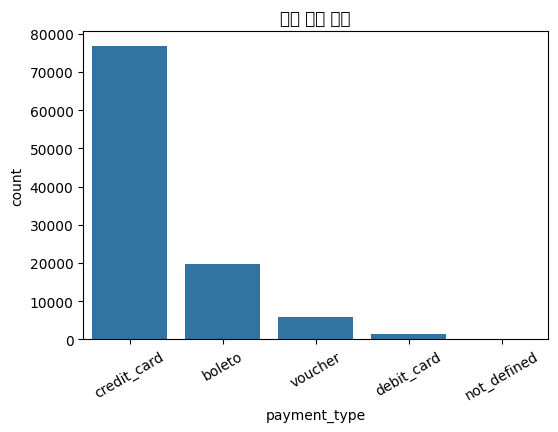


[결제 수단 비율]
payment_type
credit_card    0.739
boleto         0.190
voucher        0.056
debit_card     0.015
not_defined    0.000
Name: proportion, dtype: float64


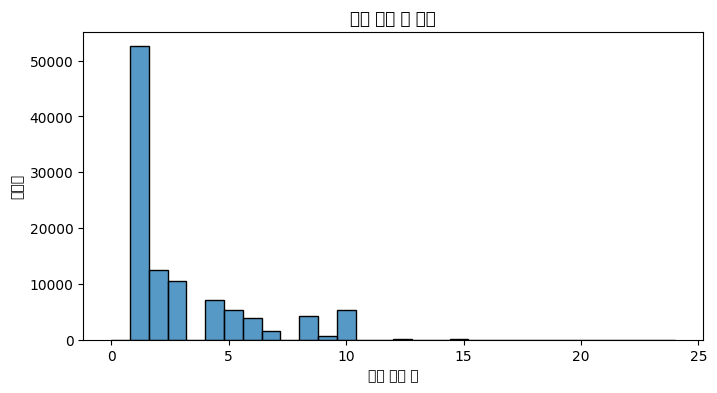


[할부 개월 수 통계]
count    103886.000000
mean          2.853349
std           2.687051
min           0.000000
25%           1.000000
50%           1.000000
75%           4.000000
max          24.000000
Name: payment_installments, dtype: float64


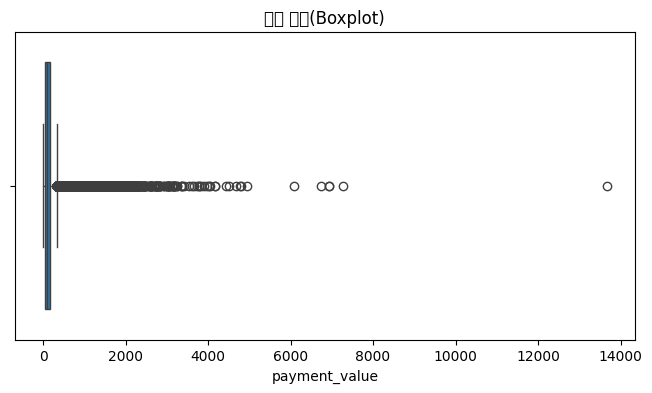

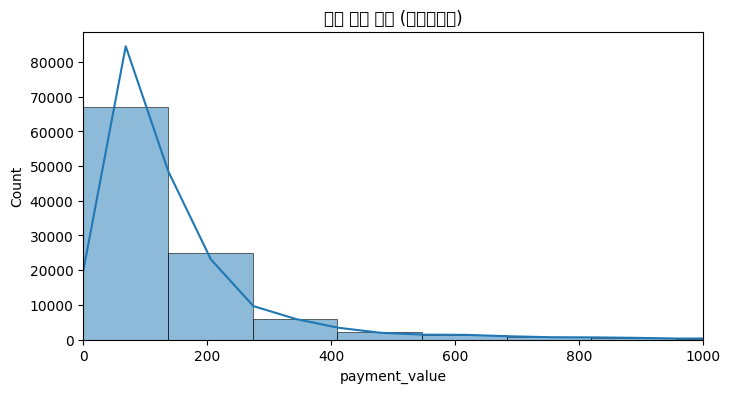


[결제 금액 통계]
count    103886.000000
mean        154.100380
std         217.494064
min           0.000000
25%          56.790000
50%         100.000000
75%         171.837500
max       13664.080000
Name: payment_value, dtype: float64


In [17]:
# df_order_payments: 결측X, 이상치 탐지

# 1. payment_type 분포 확인
plt.figure(figsize=(6,4))
sns.countplot(data=o_df_order_payments, x='payment_type', order=o_df_order_payments['payment_type'].value_counts().index)
plt.title("결제 수단 분포")
plt.xticks(rotation=30)
plt.show()

print("\n[결제 수단 비율]")
print(o_df_order_payments['payment_type'].value_counts(normalize=True).round(3))

# 2. 할부 개월 수 분포
plt.figure(figsize=(8,4))
sns.histplot(o_df_order_payments['payment_installments'], bins=30, kde=False)
plt.title("할부 개월 수 분포")
plt.xlabel("할부 개월 수")
plt.ylabel("빈도수")
plt.show()

print("\n[할부 개월 수 통계]")
print(o_df_order_payments['payment_installments'].describe())

# 3. 결제 금액 분포 (payment_value)
plt.figure(figsize=(8,4))
sns.boxplot(x=o_df_order_payments['payment_value'])
plt.title("결제 금액(Boxplot)")
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(o_df_order_payments['payment_value'], bins=100, kde=True)
plt.title("결제 금액 분포 (히스토그램)")
plt.xlim(0, 1000)  # 고액 결제는 따로 확인하기 위해 일단 1000 이하만 시각화
plt.show()

print("\n[결제 금액 통계]")
print(o_df_order_payments['payment_value'].describe())

# 결제금액 == 0 and 결제방법 확인
df_order_payments[df_order_payments['payment_value'] == 0]['payment_type'].value_counts()

# 이상치 처리: 결제금액 == 0 and 결제방법=not dine 3건 삭제
df_order_payments = df_order_payments[df_order_payments['payment_type'] != 'not_defined']


# merge

In [18]:
# 1) merge: df_order + df_order_items = merge_order_items

# 1:m로 병합
df_order_items_merged = df_order.merge(
    df_order_items,
    how="left",          
    on="order_id",
    validate="1:m"       )

# 병합 결과 점검
print("✅ Shapes (order, items, merged):", df_order.shape, df_order_items.shape, df_order_items_merged.shape)
print("✅ 주문 건수 유지 여부:",
      df_order['order_id'].nunique(), "→",
      df_order_items_merged['order_id'].nunique())

# 머지 후 결측치 대략 확인 (아이템 없는 주문이 있는지 등)
null_summary = df_order_items_merged.isna().sum().sort_values(ascending=False).head(10)
print("\n🔎 결측치 Top10 컬럼\n", null_summary)

# 1) 아이템 정보가 없는 주문 식별
mask_no_items = df_order_items_merged['order_item_id'].isna()
no_item_orders = df_order_items_merged.loc[mask_no_items, ['order_id', 'order_status']].drop_duplicates()

print("아이템 없는 주문 수(고유 order_id):", no_item_orders['order_id'].nunique())

# 2) 주문 상태 분포 (건수)
status_counts = no_item_orders['order_status'].value_counts(dropna=False)
print("\n[아이템 없는 주문의 order_status 분포 - 건수]\n", status_counts)

# 3) 주문 상태 분포 (비율)
status_ratio = no_item_orders['order_status'].value_counts(normalize=True, dropna=False).mul(100).round(2)
print("\n[아이템 없는 주문의 order_status 분포 - 비율(%)]\n", status_ratio)

## 결측치 삭제: 아이템이 없는 1,113건은 대부분 분석에서 제외
# unavailable, canceled → 제외 (아이템이 없으므로 Monetary 계산 불가)
# delivered인데 아이템 없는 336건 → 데이터 품질 이슈, 제외
# created, shipped, invoiced → 건수 적고 불완전, 제외

# 1) 아이템 있는 주문만 필터링
merge_order_items = df_order_items_merged[~df_order_items_merged['order_item_id'].isna()].copy()

# 2) 확인
print("✅ 필터링 후 행 수:", merge_order_items.shape)
print("✅ 고유 주문 수:", merge_order_items['order_id'].nunique())

# 3) order_status 분포 재확인 (정상 주문만)
print("\n[정상 주문의 order_status 분포]")
print(merge_order_items['order_status'].value_counts(normalize=True).mul(100).round(2).head())

# 4) sanity check: 아이템 없는 주문 수가 잘 제거됐는지
removed_orders = set(df_order_items_merged['order_id']) - set(merge_order_items['order_id'])
print("\n제거된 주문 수:", len(removed_orders))



✅ Shapes (order, items, merged): (99441, 12) (112267, 11) (113380, 22)
✅ 주문 건수 유지 여부: 99441 → 99441

🔎 결측치 Top10 컬럼
 carrier_to_customer              3230
order_delivered_customer_date    3229
approved_to_carrier              1983
order_delivered_carrier_date     1968
order_item_id                    1113
product_id                       1113
outlier                          1113
is_outlier                       1113
The total order value            1113
freight_value                    1113
dtype: int64
아이템 없는 주문 수(고유 order_id): 1113

[아이템 없는 주문의 order_status 분포 - 건수]
 order_status
unavailable    603
delivered      336
canceled       164
created          5
shipped          3
invoiced         2
Name: count, dtype: int64

[아이템 없는 주문의 order_status 분포 - 비율(%)]
 order_status
unavailable    54.18
delivered      30.19
canceled       14.73
created         0.45
shipped         0.27
invoiced        0.18
Name: proportion, dtype: float64
✅ 필터링 후 행 수: (112267, 22)
✅ 고유 주문 수: 98328

[정상 주문의 order_s

In [19]:
# 2) inner join 병합: merge_order_items + df_customers = merge_oic

# 0) 안전장치: 키/타입 점검
assert 'customer_id' in merge_order_items.columns, "merge_order_items에 customer_id가 없습니다."
assert 'customer_id' in df_customers.columns, "df_customers에 customer_id가 없습니다."

merge_order_items = merge_order_items.copy()
df_customers = df_customers.copy()

merge_order_items['customer_id'] = merge_order_items['customer_id'].astype(str)
df_customers['customer_id'] = df_customers['customer_id'].astype(str)

# 1) 고객 테이블에서 customer_id 중복 제거 (m:1 보장)
dup_cnt = df_customers['customer_id'].duplicated().sum()
if dup_cnt > 0:
    print(f"[알림] df_customers에 customer_id 중복 {dup_cnt}건 → 첫 번째만 사용")
df_customers_dedup = df_customers.drop_duplicates(subset='customer_id', keep='first')

# 2) 병합 (m:1 관계)
merge_oic = merge_order_items.merge(
    df_customers_dedup,
    how='left',                 # 주문–아이템은 유지, 고객정보 없으면 NaN
    on='customer_id',
    validate='m:1',             # many:one 관계 보장
    suffixes=('', '_cust')      # 혹시 중복 컬럼 있을 때 고객쪽 접미사
)

# 3) 결과 점검
print("✅ Shapes (order_items, customers, merged):",
      merge_order_items.shape, df_customers_dedup.shape, merge_oic.shape)

# 병합으로 행 수가 늘거나 줄지 확인 (m:1이면 행 수 동일해야 정상)
if merge_oic.shape[0] != merge_order_items.shape[0]:
    print("[주의] 병합 후 행 수가 달라졌습니다. 예상치와 다르면 키 중복/결측 여부를 확인하세요.")

# 고객 정보 매칭률 확인
missing_cust = merge_oic['customer_city'].isna().sum() if 'customer_city' in merge_oic.columns else None
if missing_cust is not None:
    total_rows = merge_oic.shape[0]
    print(f"🔎 고객 정보 결측 행 수: {missing_cust} ({missing_cust/total_rows*100:.2f}%)")

# 결측치 많은 고객 컬럼 Top5
cust_cols = [c for c in ['customer_unique_id','customer_zip_code_prefix','customer_city','customer_state'] if c in merge_oic.columns]
if cust_cols:
    print("\n[고객 컬럼 결측치]")
    print(merge_oic[cust_cols].isna().sum().sort_values(ascending=False))


✅ Shapes (order_items, customers, merged): (112267, 22) (99441, 5) (112267, 26)
🔎 고객 정보 결측 행 수: 0 (0.00%)

[고객 컬럼 결측치]
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64


In [20]:
# 3) merge_oic + df_sellers = merge_oics

# 0) 안전장치: 키/타입 점검
assert 'seller_id' in merge_oic.columns, "merge_oic에 seller_id가 없습니다."
assert 'seller_id' in df_sellers.columns, "df_sellers에 seller_id가 없습니다."

merge_oic = merge_oic.copy()
df_sellers = df_sellers.copy()

merge_oic['seller_id'] = merge_oic['seller_id'].astype(str)
df_sellers['seller_id'] = df_sellers['seller_id'].astype(str)

# 1) 셀러 테이블에서 seller_id 중복 제거 (m:1 보장)
dup_cnt = df_sellers['seller_id'].duplicated().sum()
if dup_cnt > 0:
    print(f"[알림] df_sellers에 seller_id 중복 {dup_cnt}건 → 첫 번째만 사용")
df_sellers_dedup = df_sellers.drop_duplicates(subset='seller_id', keep='first')

# 2) 병합 (m:1)
merge_oics = merge_oic.merge(
    df_sellers_dedup,
    how='left',                  # 주문·아이템은 유지, 셀러 정보 없으면 NaN
    on='seller_id',
    validate='m:1',              # many:one 관계 확인
    suffixes=('', '_seller')     # 셀러 쪽 충돌 컬럼에 접미사
)

# 3) 결과 점검
print("✅ Shapes (oic, sellers, merged):",
      merge_oic.shape, df_sellers_dedup.shape, merge_oics.shape)


✅ Shapes (oic, sellers, merged): (112267, 26) (3095, 4) (112267, 29)


# 과제 1: 고객 세분화 및 RFM 분석
브라질 지역별 고객들의 구매 패턴을 분석하여 RFM(Recency, Frequency, Monetary) 모델을 구축하고,
고객을 세분화하여 각 세그먼트의 특성과 비즈니스 전략을 제시

In [21]:
# 1. 기준일 설정 (Recency 계산용)
# ---------------------------
today_date = merge_oics['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

# ---------------------------
# 2. 고객별 RFM 집계
# ---------------------------
rfm = (
    merge_oics.groupby('customer_id').agg({
        'order_purchase_timestamp': lambda x: (today_date - x.max()).days,   # Recency
        'order_id': 'nunique',                                             # Frequency
        'price': 'sum'                                                     # Monetary
    })
    .reset_index()
)

rfm.rename(columns={
    'order_purchase_timestamp': 'Recency',
    'order_id': 'Frequency',
    'price': 'Monetary'
}, inplace=True)


# 3. RFM 점수화
# Recency (작을수록 우수 → 반대로 점수 부여)
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1], duplicates='drop').astype(str)

# Frequency (3단계 단순화: 1 / 2~3 / 4회 이상)
rfm['F_score'] = pd.cut(
    rfm['Frequency'],
    bins=[0,1,3, np.inf],     # (0~1] / (1~3] / (3~∞]
    labels=[1,2,3],           # 1=일회성, 2=재구매, 3=충성
    right=True
).astype(str)

# Monetary (금액 클수록 우수)
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5], duplicates='drop').astype(str)

# 4. 고객 세그먼트 분류 (규칙 적용)
def segment_customer(row):
    if row['R_score'] in ['4','5'] and row['F_score'] in ['2','3']:
        return '우수 고객 (VIP)'
    elif row['R_score'] in ['3','4','5'] and row['F_score'] == '1':
        return '잠재 충성 고객'
    elif row['R_score'] in ['1','2'] and row['F_score'] in ['2','3']:
        return '이탈 위험 고객'
    elif row['R_score'] in ['1','2'] and row['F_score'] == '1':
        return '이탈 고객'
    else:
        return '일반 고객'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

print(rfm[['customer_id','Recency','Frequency','Monetary',
           'R_score','F_score','M_score','Segment']].head())

print("\n[세그먼트별 고객 수]")
print(rfm['Segment'].value_counts())


                        customer_id  Recency  Frequency  Monetary R_score  \
0  00012a2ce6f8dcda20d059ce98491703      293          1     89.80       2   
1  000161a058600d5901f007fab4c27140      414          1     54.90       1   
2  0001fd6190edaaf884bcaf3d49edf079      552          1    179.99       1   
3  0002414f95344307404f0ace7a26f1d5      383          1    149.90       2   
4  000379cdec625522490c315e70c7a9fb      154          1     93.00       4   

  F_score M_score   Segment  
0       1       3     이탈 고객  
1       1       2     이탈 고객  
2       1       5     이탈 고객  
3       1       4     이탈 고객  
4       1       3  잠재 충성 고객  

[세그먼트별 고객 수]
Segment
잠재 충성 고객    59039
이탈 고객       39289
Name: count, dtype: int64


=== 전체 매출 대비 고객 등급별 매출 비율 (%) ===
Segment
잠재 충성 고객    59.69
이탈 고객       40.31
Name: Monetary, dtype: float64

=== 고객 등급별 평균 구매액 ===
Segment
이탈 고객       139.07
잠재 충성 고객    137.03
Name: Monetary, dtype: float64
=== VIP 고객 (상위 20% 지출) 현황 ===
VIP 고객 수: 19685 / 전체 고객 수: 98328 (20.02%)
VIP 매출: 7,671,432.44 / 전체 매출: 13,553,879.33 (56.60%)


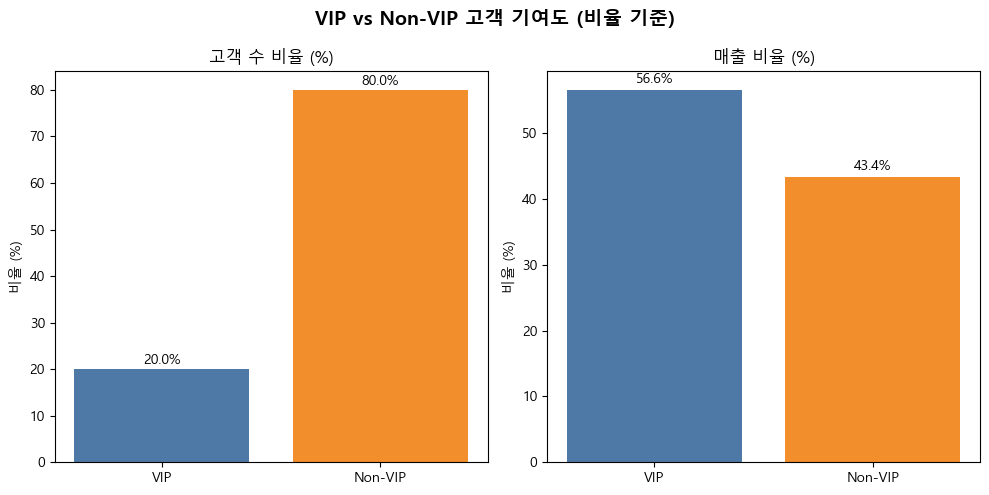

In [22]:
## 1. 전체 매출 대비 고객 등급별 매출 비율
segment_sales = (
    rfm.groupby('Segment')['Monetary']
    .sum()
    .sort_values(ascending=False)
)
total_sales = segment_sales.sum()
segment_sales_ratio = (segment_sales / total_sales) * 100

print("=== 전체 매출 대비 고객 등급별 매출 비율 (%) ===")
print(segment_sales_ratio.round(2))

## 2. 고객 등급별 평균 구매액
segment_avg_purchase = (
    rfm.groupby('Segment')['Monetary']
    .mean()
    .sort_values(ascending=False)
)
print("\n=== 고객 등급별 평균 구매액 ===")
print(segment_avg_purchase.round(2))

##3. VIP고객 매출액 비율
# VIP 기준: 상위 20% 지출 고객
threshold = rfm['Monetary'].quantile(0.80)
rfm['is_VIP'] = (rfm['Monetary'] >= threshold).astype(int)
vip_customers = rfm[rfm['is_VIP'] == 1]
vip_count = vip_customers.shape[0]
total_count = rfm.shape[0]

vip_sales = vip_customers['Monetary'].sum()
total_sales = rfm['Monetary'].sum()

print("=== VIP 고객 (상위 20% 지출) 현황 ===")
print(f"VIP 고객 수: {vip_count} / 전체 고객 수: {total_count} ({vip_count/total_count*100:.2f}%)")
print(f"VIP 매출: {vip_sales:,.2f} / 전체 매출: {total_sales:,.2f} ({vip_sales/total_sales*100:.2f}%)")

# 시각화
plt.rcParams['font.family'] = 'Malgun Gothic'  
plt.rcParams['axes.unicode_minus'] = False 
# VIP / Non-VIP 데이터
vip_count = rfm[rfm['is_VIP'] == 1].shape[0]
nonvip_count = rfm[rfm['is_VIP'] == 0].shape[0]

vip_sales = rfm.loc[rfm['is_VIP'] == 1, 'Monetary'].sum()
nonvip_sales = rfm.loc[rfm['is_VIP'] == 0, 'Monetary'].sum()

# 비율 계산
count_ratio = [vip_count / (vip_count + nonvip_count) * 100,
               nonvip_count / (vip_count + nonvip_count) * 100]
sales_ratio = [vip_sales / (vip_sales + nonvip_sales) * 100,
               nonvip_sales / (vip_sales + nonvip_sales) * 100]

labels = ['VIP', 'Non-VIP']

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 고객 수 비율
axes[0].bar(labels, count_ratio, color=['#4e79a7', '#f28e2b'])
axes[0].set_title("고객 수 비율 (%)")
axes[0].set_ylabel("비율 (%)")
for i, v in enumerate(count_ratio):
    axes[0].text(i, v + 1, f"{v:.1f}%", ha='center')

# 매출 비율
axes[1].bar(labels, sales_ratio, color=['#4e79a7', '#f28e2b'])
axes[1].set_title("매출 비율 (%)")
axes[1].set_ylabel("비율 (%)")
for i, v in enumerate(sales_ratio):
    axes[1].text(i, v + 1, f"{v:.1f}%", ha='center')

plt.suptitle("VIP vs Non-VIP 고객 기여도 (비율 기준)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()




customer_state
SP    5192899.66
RJ    1815534.97
MG    1580228.93
RS     748801.22
PR     681181.67
SC     518904.84
BA     509699.39
DF     302144.44
GO     293445.95
ES     273419.01
PE     262040.63
CE     226251.31
PA     178877.91
MT     156122.84
MA     119548.32
MS     116533.04
PB     114829.38
PI      86760.28
RN      82765.28
AL      79943.21
SE      58820.95
TO      49551.84
RO      46030.64
AM      22356.84
AC      15982.95
AP      13374.40
RR       7829.43
Name: price, dtype: float64
customer_state
SP    38.31
RJ    13.39
MG    11.66
RS     5.52
PR     5.03
SC     3.83
BA     3.76
DF     2.23
GO     2.17
ES     2.02
PE     1.93
CE     1.67
PA     1.32
MT     1.15
MA     0.88
MS     0.86
PB     0.85
PI     0.64
RN     0.61
AL     0.59
SE     0.43
TO     0.37
RO     0.34
AM     0.16
AC     0.12
AP     0.10
RR     0.06
Name: price, dtype: float64


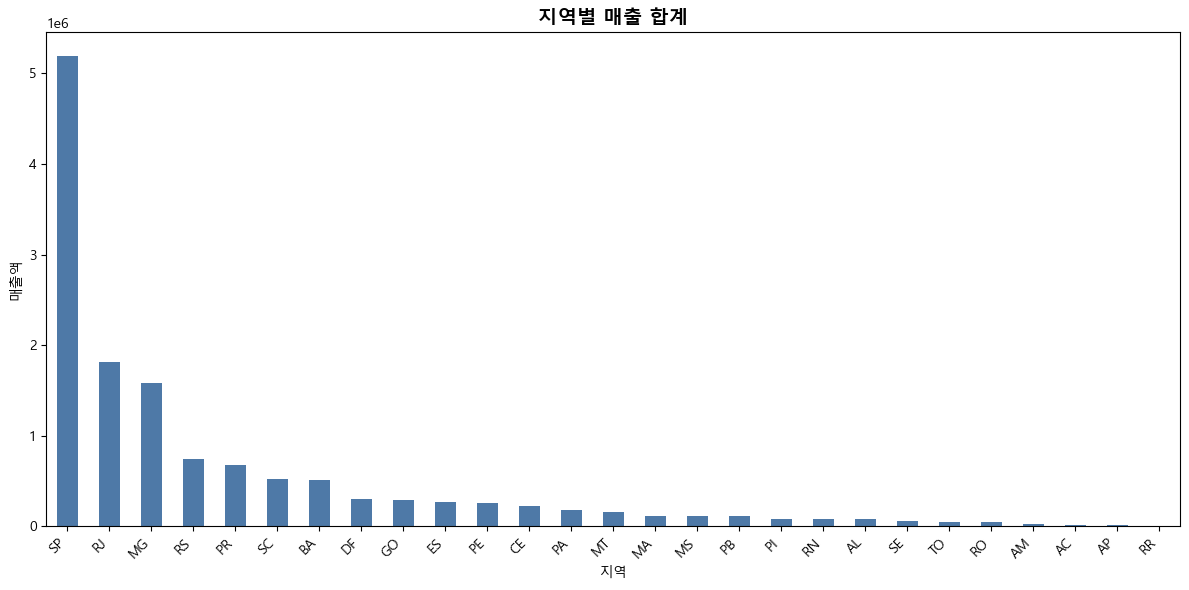

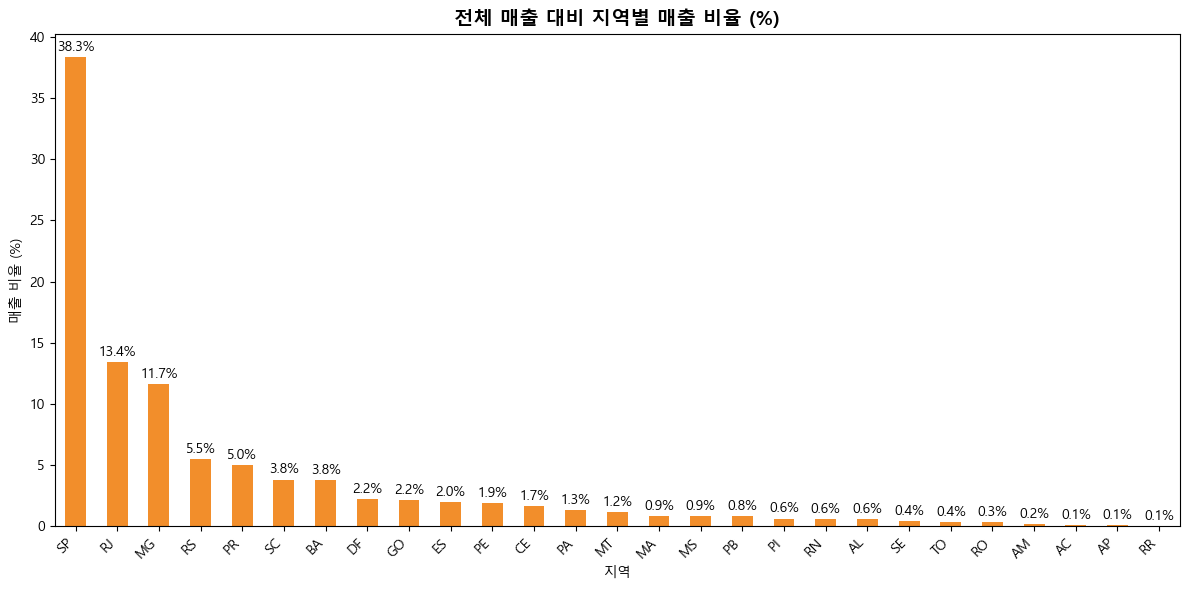

In [23]:
# 3. 지역별 매출 합계
region_sales = (
    merge_oics.groupby('customer_state')['price']
    .sum()
    .sort_values(ascending=False)
)
print(region_sales.round(2))

# 4. 전체 매출 대비 지역별 매출 비율
region_sales_ratio = (region_sales / region_sales.sum()) * 100
print(region_sales_ratio.round(2))

import matplotlib.pyplot as plt

# 시각화
# 1) 지역별 매출 합계 바그래프
plt.figure(figsize=(12,6))
region_sales.plot(kind='bar', color='#4e79a7')
plt.title("지역별 매출 합계", fontsize=14, fontweight='bold')
plt.xlabel("지역")
plt.ylabel("매출액")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2) 지역별 매출 비율 바그래프
plt.figure(figsize=(12,6))
region_sales_ratio.plot(kind='bar', color='#f28e2b')
plt.title("전체 매출 대비 지역별 매출 비율 (%)", fontsize=14, fontweight='bold')
plt.xlabel("지역")
plt.ylabel("매출 비율 (%)")
plt.xticks(rotation=45, ha='right')

for i, v in enumerate(region_sales_ratio):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center')
plt.tight_layout()
plt.show()
